<a href="https://colab.research.google.com/github/ClashLuke/NextPrediction/blob/master/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting with the actual code, we should clone the repository and import it into our python instance. To ensure reproduceability, a constant seed (999) for the random number generator is used.

In [1]:
!git clone https://www.github.com/clashluke/nextprediction --recursive

from nextprediction import AutoEncoder

Cloning into 'nextprediction'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 218 (delta 121), reused 159 (delta 76), pack-reused 0
Receiving objects: 100% (218/218), 10.51 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Submodule 'LocAtE' (https://www.github.com/ClashLuke/LocAtE) registered for path 'LocAtE'
Cloning into '/content/nextprediction/LocAtE'...
remote: Enumerating objects: 82, done.        
remote: Counting objects: 100% (82/82), done.        
remote: Compressing objects: 100% (58/58), done.        
remote: Total 82 (delta 43), reused 55 (delta 23), pack-reused 0        
Submodule path 'LocAtE': checked out '07768317e072eda28b5f18b05c70e497234896c0'


The model we will define below is an AutoEncoder based on a ResNet architecture, made up of blocks. Each block contains several residual modules, made up of convolutional layers.\
Below we define parameters used to create the model.

In [0]:
inputs = 1  # Number of input and output trips to the model
feature_list = [6 * 16] * 3  # Features used in convolutional layer.
                             # Each element adds one "Block"
learning_rate = 1e-3  # Constant learning rate used to train model

Next, let's create an instance of the model using the parameters defined above and show its shape as well as its total number of parameters.

In [27]:
model = AutoEncoder(feature_list, inputs, learning_rate)
print(model)
print(f'Parameters: {model.parameters}')

BlockBlock(
  (block_0): Block(
    (scale_layer): CatModule(
      (layer_module): SpectralNorm(
        (module): Conv1d(6, 90, kernel_size=(1,), stride=(1,))
      )
    )
    (res_module_i): ResModule(
      (layer_module): Norm(
        (i_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (module): InceptionBlock(
          (factorized_conv_0): FactorizedConvModule(
            (nlin_0): RootTanhModule()
            (layer_0): SpectralNorm(
              (module): Conv1d(6, 6, kernel_size=[1], stride=[1], padding=[0], bias=False)
            )
            (nlin_1): RootTanhModule()
            (layer_1): SpectralNorm(
              (module): Conv1d(6, 6, kernel_size=[3], stride=[1], padding=[1], bias=False)
            )
            (nlin_2): RootTanhModule()
            (layer_2): SpectralNorm(
              (module): Conv1d(6, 6, kernel_size=[3], stride=[1], padding=[1], bias=False)
            )
            (nlin_3): RootTanhModule()

Before starting with the real magic, we have to add a dataset to the model. [NextBike](https://www.nextbike.de/de/) was kind enough to allow their dataset to be used.\
To add it, we first have call the add_datasets() function which reads all given inputs, parses them and adds theme to the list of datasets. Afterwords we can split the dataset into training, testing and evaluation datasets, making it easy to check how accurate the model is.

In [0]:
model.add_datasets('nextprediction/nextbike.csv')
model.dataset.split()

Lastly, we have to add a mask and a batch size schedule.

The former is used to zero out random inputs to the AutoEncoder, so that it has to regenerate these from the inputs. It zeroes them out by picking one element of each input list and setting the item at the given indices to zero.

The latter is used to let the model consider more than one sample when updating itself to fit the given data better. Higher batch sizes can keep the model from "remembering" the training data and make training faster, but can also prevent the model from finding the best solution.\
The scheduler accepts an int, a list of integers or a function transforming the current epoch (starting with zero) into an integer. 

In [0]:
model.add_mask([0, 1], [[2, 3], [4, 5]])
model.add_batch_size_schedule(8192)

As a final step, we can train the model by calling the train() function and passing the desired number of epochs over the entire dataset as well as the log level as inputs. Note that, while the model is training, it will generate a graph plotting the training/testing error in the plots folder. A smoothed out graph, using the linear weighted moving average, is created as well.

To validate that the model did train successfully, we will then use the previously generated evaluation dataset to also evaluate() the models performance. The evaluate function will show an accurate loss (which can not be translated directly to accuracy) on the evaluation dataset.

[0][1/1] Loss: 0.5115 | Elapsed: 1
[0][1/1] Loss: 0.5513 | Elapsed: 1
	[[1567477905.6476989, 1567480334.7728078, 51.62120039846086, 13.619039527452795, 51.621627670646795, 13.620422938395121], [1567463415.8631215, 1567465848.1051579, 51.616455349204855, 13.617433778618256, 51.616650224442296, 13.618417957970001], [1567339574.269464, 1567342033.151319, 51.575900263053775, 13.603709730919629, 51.574108883194725, 13.601281749369194], [1567388889.603047, 1567391337.8765795, 51.592049825918366, 13.609174825241954, 51.59104939867686, 13.608105610549726], [1567448588.9105773, 1567451024.3420696, 51.611599885704806, 13.615790665041198, 51.611556956266234, 13.616366322940046], [1567376661.975135, 1567379112.8789778, 51.588045577517306, 13.607819767189591, 51.586849035323304, 13.606413649259489]]
	[[1567417082.5964618, 1567419524.805342, 51.60128234015715, 13.612299155081109, 51.600734091179845, 13.612006731344202], [1567366150.0564516, 1567368603.2215347, 51.584603181830765, 13.606654842957308,

0.2587104528147955

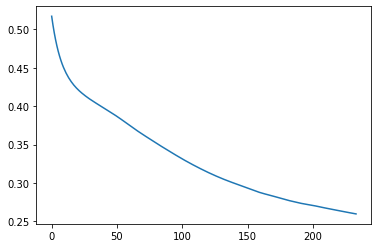

In [30]:
model.train(250, 1)
model.evaluate()